Introduction

Some questions to be answered:

    What are the main predictors for churn prediction?
    
    What is more important to churning, having big contracts  or longer tenure?
    
    Is it the monthly charges or total charges as a whole?
    
    There are some features that can be modified and depends on the customer but there are some other features like cannot be changed like gender or partner of the customer, which group is effecting churn?
    
    Is it possible to predict the customer churn with the training data provided using machine learning techniques?
    
    What can predictions achieve with different approaches?
    
    If stack and blend the models, can get more regularized results?



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

pd.set_option('display.max_columns', None)
import warnings 
warnings.filterwarnings('ignore')

import time
#from dython.nominal import associations

In [63]:
from sklearn.feature_selection import mutual_info_classif
def make_mi_scores_Classifier(X_train, y_train):
    # All discrete features should now have integer dtypes (double-check this before using MI!)
    discrete_features = X_train.dtypes == int
    mi_scores = mutual_info_classif(X_train, y_train, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(figsize=(20,14))
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [75]:
data = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(data.shape)
data.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [233]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

## Churn Rate

In [232]:
global_churn = round((data.Churn=='Yes').sum()/data.shape[0],2)
global_churn

0.27

In [237]:
columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']

In [240]:
(data.Churn =='Yes')

0       False
1       False
2        True
3       False
4        True
        ...  
7038    False
7039    False
7040    False
7041     True
7042    False
Name: Churn, Length: 7043, dtype: bool

In [242]:
for col in columns:  
    print(col)
    print()
    for gr_name , grp in data.groupby(col):
        #display(grp.Churn)
        print(f' global churn = {global_churn}')
        churn_rate = (grp.Churn =='Yes').mean()
        print(f'churn rate for {gr_name}  =  {np.round(churn_rate,2)}')
        print('=====================')
        print()

gender

 global churn = 0.27
churn rate for Female  =  0.27

 global churn = 0.27
churn rate for Male  =  0.26

SeniorCitizen

 global churn = 0.27
churn rate for 0  =  0.24

 global churn = 0.27
churn rate for 1  =  0.42

Partner

 global churn = 0.27
churn rate for No  =  0.33

 global churn = 0.27
churn rate for Yes  =  0.2

Dependents

 global churn = 0.27
churn rate for No  =  0.31

 global churn = 0.27
churn rate for Yes  =  0.15

PhoneService

 global churn = 0.27
churn rate for No  =  0.25

 global churn = 0.27
churn rate for Yes  =  0.27

MultipleLines

 global churn = 0.27
churn rate for No  =  0.25

 global churn = 0.27
churn rate for No phone service  =  0.25

 global churn = 0.27
churn rate for Yes  =  0.29

InternetService

 global churn = 0.27
churn rate for DSL  =  0.19

 global churn = 0.27
churn rate for Fiber optic  =  0.42

 global churn = 0.27
churn rate for No  =  0.07

OnlineSecurity

 global churn = 0.27
churn rate for No  =  0.42

 global churn = 0.27
churn rat

## Risk Ratio

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score,recall_score ,f1_score
from sklearn.ensemble import RandomForestClassifier

In [144]:
    def adding_similar_features_Categorical(df,new_col,features):
        df=df.copy()
        new_feature = new_col
        combi = df[features].values
        df[new_feature] = [ '_'.join(feat) for feat in combi]
        return df

In [50]:
df.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [224]:
def preprocessing(df):
    df = df.copy()

    df.columns = df.columns.str.lower().str.replace(' ', '_')

    string_columns = list(df.dtypes[df.dtypes == 'object'].index)

    for col in string_columns:
        df[col] = df[col].str.lower().str.replace(' ', '_')

    df.churn = (df.churn == 'yes').astype(int)
    
    df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
    df['totalcharges'] = df['totalcharges'].fillna(0)
    df['total_charges_per_month'] = df['totalcharges'] / df['monthlycharges']
    df['tenure_totalcharges'] = df['totalcharges'] * df['totalcharges']
    X= df[['total_charges_per_month','tenure_totalcharges']]
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    df[['total_charges_per_month','tenure_totalcharges']] = X
    return df

In [225]:
preprocessing(data)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,total_charges_per_month,tenure_totalcharges
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,yes,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0,-1.275553,-0.646066
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,no,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,0,0.032721,-0.422916
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,yes,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,1,-1.234556,-0.645390
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,no,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,0,0.453047,-0.434285
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,no,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,1,-1.229002,-0.644684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-resvb,male,0,yes,yes,24,yes,yes,dsl,yes,no,yes,yes,yes,yes,one_year,yes,mailed_check,84.80,1990.50,0,-0.361871,-0.398416
7039,2234-xaduh,female,0,yes,yes,72,yes,yes,fiber_optic,no,yes,yes,no,yes,yes,one_year,yes,credit_card_(automatic),103.20,7362.90,0,1.584509,2.743172
7040,4801-jzazl,female,0,yes,yes,11,no,no_phone_service,dsl,yes,no,no,no,no,no,month-to-month,yes,electronic_check,29.60,346.45,0,-0.840343,-0.638617
7041,8361-ltmkd,male,1,yes,no,4,yes,yes,fiber_optic,no,no,no,no,no,no,month-to-month,yes,mailed_check,74.40,306.60,1,-1.148664,-0.640244


In [152]:
def preprocessing2(df):
    df = df.copy()   
    df = adding_similar_features_Categorical(df,new_col='partner_dependents',features=['partner','dependents'])#
    df = adding_similar_features_Categorical(df,new_col='phone_internet',features=['phoneservice','internetservice'])#
    #df = adding_similar_features_Categorical(df,new_col='phone_billing',features=['phoneservice','paperlessbilling'])
    df = adding_similar_features_Categorical(df,new_col='tech_internet',features=['techsupport','internetservice'])##
    df = adding_similar_features_Categorical(df,new_col='contract_techsupport',features=['contract','techsupport'])#
    df = adding_similar_features_Categorical(df,new_col='contract_partner',features=['contract','partner'])#
    df = adding_similar_features_Categorical(df,new_col='contract_internetservice',features=['contract','internetservice'])
    #df = adding_similar_features_Categorical(df,new_col='contract_phoneservice',features=['contract','phoneservice'])
    #df = adding_similar_features_Categorical(df,new_col='contract_onlinesecurity',features=['contract','onlinesecurity'])
    #df = adding_similar_features_Categorical(df,new_col='contract_paymentmethod',features=['contract','paymentmethod'])
    
    df = df.drop(['multiplelines','customerid', 'gender'],axis=1)
    return df

In [68]:
numerical

['tenure', 'monthlycharges', 'totalcharges']

In [226]:
df = preprocessing(df=data)

In [150]:
df

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,total_charges_per_month,tenure_totalcharges
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,yes,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0,1.000000,8.910225e+02
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,no,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,0,33.178227,3.570210e+06
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,yes,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,1,2.008357,1.169642e+04
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,no,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,0,43.516548,3.388361e+06
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,no,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,1,2.144979,2.299772e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-resvb,male,0,yes,yes,24,yes,yes,dsl,yes,no,yes,yes,yes,yes,one_year,yes,mailed_check,84.80,1990.50,0,23.472877,3.962090e+06
7039,2234-xaduh,female,0,yes,yes,72,yes,yes,fiber_optic,no,yes,yes,no,yes,yes,one_year,yes,credit_card_(automatic),103.20,7362.90,0,71.345930,5.421230e+07
7040,4801-jzazl,female,0,yes,yes,11,no,no_phone_service,dsl,yes,no,no,no,no,no,month-to-month,yes,electronic_check,29.60,346.45,0,11.704392,1.200276e+05
7041,8361-ltmkd,male,1,yes,no,4,yes,yes,fiber_optic,no,no,no,no,no,no,month-to-month,yes,mailed_check,74.40,306.60,1,4.120968,9.400356e+04


In [153]:
df1 = preprocessing2(df=df)

In [154]:
df1.head()

,seniorcitizen,partner,dependents,tenure,phoneservice,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,total_charges_per_month,tenure_totalcharges,partner_dependents,phone_internet,tech_internet,contract_techsupport,contract_partner,contract_internetservice
0,0,yes,no,1,no,dsl,no,yes,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0,1.000000,8.910225e+02,yes_no,no_dsl,no_dsl,month-to-month_no,month-to-month_yes,month-to-month_dsl
1,0,no,no,34,yes,dsl,yes,no,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,0,33.178227,3.570210e+06,no_no,yes_dsl,no_dsl,one_year_no,one_year_no,one_year_dsl
2,0,no,no,2,yes,dsl,yes,yes,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,1,2.008357,1.169642e+04,no_no,yes_dsl,no_dsl,month-to-month_no,month-to-month_no,month-to-month_dsl
3,0,no,no,45,no,dsl,yes,no,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,0,43.516548,3.388361e+06,no_no,no_dsl,yes_dsl,one_year_yes,one_year_no,one_year_dsl
4,0,no,no,2,yes,fiber_optic,no,no,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,1,2.144979,2.299772e+04,no_no,yes_fiber_optic,no_fiber_optic,month-to-month_no,month-to-month_no,month-to-month_fiber_optic


In [94]:
df['total_charges_per_month'].describeribe()

count    1409.000000
mean       32.669425
std        24.574924
min         0.000000
25%         9.366234
50%        29.105459
75%        55.643443
max        77.377778
Name: total_charges_per_month, dtype: float64

In [227]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

In [156]:
df_train_full1, df_test1 = train_test_split(df1, test_size=0.2, random_state=1)
df_train1, df_val1 = train_test_split(df_train_full1, test_size=0.33, random_state=11)

y_train1 = df_train1.churn.values
y_val1 = df_val1.churn.values

del df_train1['churn']
del df_val1['churn']

In [127]:
df_train_full.shape ,df_test.shape , df_train.shape , df_val.shape

((5634, 23), (1409, 23), (3774, 22), (1860, 22))

In [140]:
df_train_full1.shape ,df_test1.shape , df_train1.shape , df_val1.shape

((5634, 30), (1409, 30), (3774, 29), (1860, 29))

In [141]:
for df in [df_train_full1,df_test1]:#,df_train,df_val]:
    display(df.churn.value_counts()/df.churn.shape[0])
    print()

0    0.730032
1    0.269968
Name: churn, dtype: float64

0    0.753016
1    0.246984
Name: churn, dtype: float64

In [25]:
y_train.shape[0]

3774

In [83]:
np.unique(y_train,return_counts=True)[1] / y_train.shape[0]

array([0.72575517, 0.27424483])

In [84]:
np.unique(y_val,return_counts=True)[1] / y_val.shape[0]

array([0.73870968, 0.26129032])

In [182]:
def train(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model
def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [106]:
def Dict_df(df):
    df = df.copy()
    
    dv_X = DictVectorizer(sparse=False)
    ds = df[categorical + numerical].to_dict(orient='records')
    dv_X.fit(ds)
    Xs = pd.DataFrame(dv_X.transform(ds))
    Xs.columns = dv_X.get_feature_names()
    return Xs

In [157]:
df_dict = Dict_df(df=df_train1)
df_dict.head()

,contract=month-to-month,contract=one_year,contract=two_year,contract_internetservice=month-to-month_dsl,contract_internetservice=month-to-month_fiber_optic,contract_internetservice=month-to-month_no,contract_internetservice=one_year_dsl,contract_internetservice=one_year_fiber_optic,contract_internetservice=one_year_no,contract_internetservice=two_year_dsl,contract_internetservice=two_year_fiber_optic,contract_internetservice=two_year_no,contract_partner=month-to-month_no,contract_partner=month-to-month_yes,contract_partner=one_year_no,contract_partner=one_year_yes,contract_partner=two_year_no,contract_partner=two_year_yes,contract_techsupport=month-to-month_no,contract_techsupport=month-to-month_no_internet_service,contract_techsupport=month-to-month_yes,contract_techsupport=one_year_no,contract_techsupport=one_year_no_internet_service,contract_techsupport=one_year_yes,contract_techsupport=two_year_no,contract_techsupport=two_year_no_internet_service,contract_techsupport=two_year_yes,dependents=no,dependents=yes,deviceprotection=no,deviceprotection=no_internet_service,deviceprotection=yes,internetservice=dsl,internetservice=fiber_optic,internetservice=no,monthlycharges,onlinebackup=no,onlinebackup=no_internet_service,onlinebackup=yes,onlinesecurity=no,onlinesecurity=no_internet_service,onlinesecurity=yes,paperlessbilling=no,paperlessbilling=yes,partner=no,partner=yes,partner_dependents=no_no,partner_dependents=no_yes,partner_dependents=yes_no,partner_dependents=yes_yes,paymentmethod=bank_transfer_(automatic),paymentmethod=credit_card_(automatic),paymentmethod=electronic_check,paymentmethod=mailed_check,phone_internet=no_dsl,phone_internet=yes_dsl,phone_internet=yes_fiber_optic,phone_internet=yes_no,phoneservice=no,phoneservice=yes,seniorcitizen,streamingmovies=no,streamingmovies=no_internet_service,streamingmovies=yes,streamingtv=no,streamingtv=no_internet_service,streamingtv=yes,tech_internet=no_dsl,tech_internet=no_fiber_optic,tech_internet=no_internet_service_no,tech_internet=yes_dsl,tech_internet=yes_fiber_optic,techsupport=no,techsupport=no_internet_service,techsupport=yes,tenure,tenure_totalcharges,total_charges_per_month,totalcharges
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,86.10,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,71.0,3.655291e+07,70.219512,6045.90
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,100.50,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,60.0,3.634884e+07,59.990050,6029.00
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,45.20,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,46.0,4.264845e+06,45.689159,2065.15
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,69.15,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4.781723e+03,1.000000,69.15
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,98.55,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,20.0,3.395912e+06,18.699137,1842.80


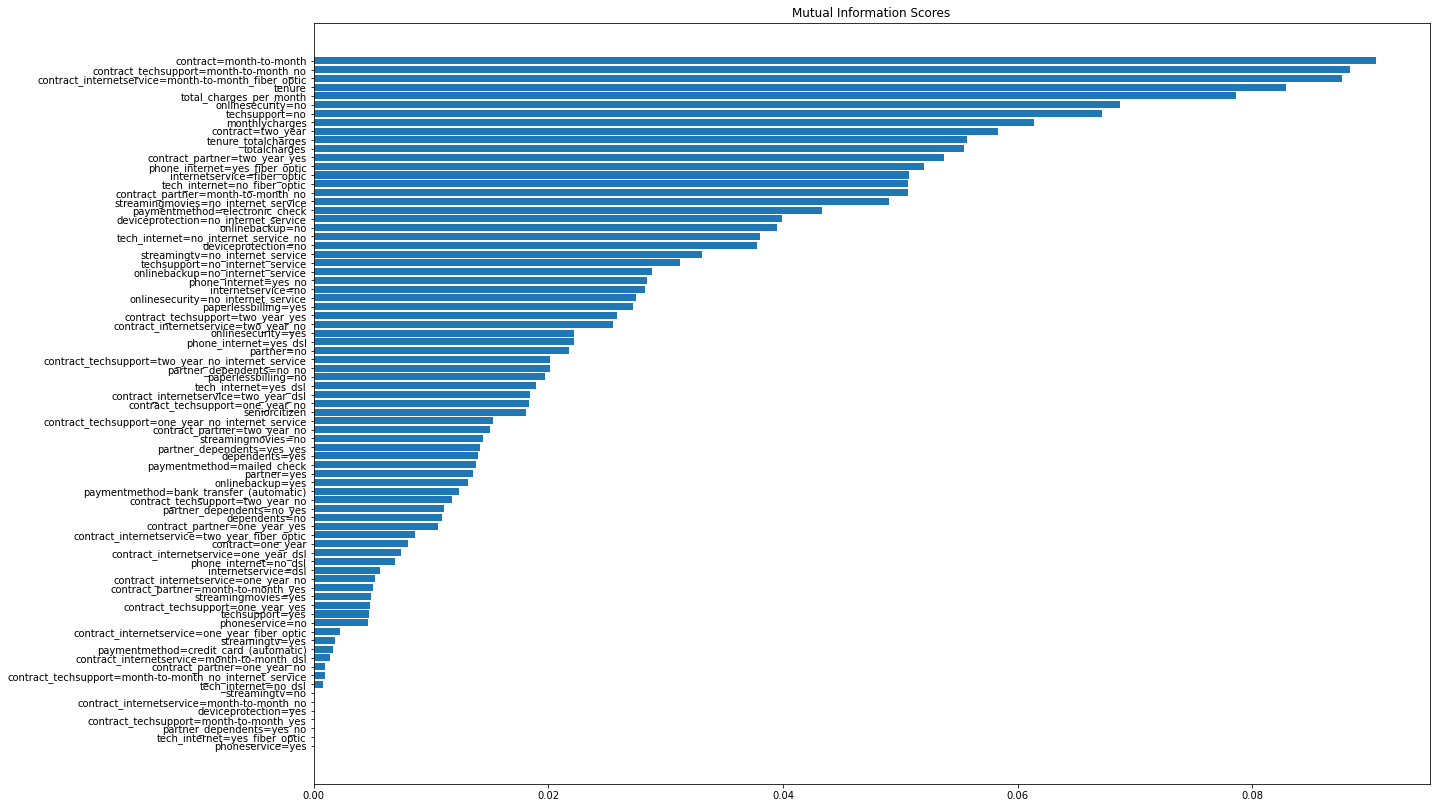

In [158]:
mi_scores = make_mi_scores_Classifier(X_train=df_dict, y_train=y_train1)
plot_mi_scores(scores=mi_scores)

In [130]:
mi_scores.to_dict()

{'concat_contract_onlinesecurity=month-to-month_no': 0.1006434448983371,
 'contract=month-to-month': 0.09171626508420716,
 'concat_contract_internetservice=month-to-month_fiber_optic': 0.09110595098069751,
 'concat_contract_techsupport=month-to-month_no': 0.08591630993427879,
 'tenure': 0.08269269088099107,
 'total_charges_per_month': 0.0814328686106589,
 'concat_contract_phoneservice=month-to-month_yes': 0.07100610749880598,
 'concat_tech_internet=no_fiber_optic': 0.06960033238395735,
 'contract=two_year': 0.06947806365947984,
 'onlinesecurity=no': 0.06849307169760999,
 'monthlycharges': 0.06174200497398652,
 'concat_contract_phoneservice=two_year_yes': 0.0595658134590924,
 'concat_phone_internet=yes_fiber_optic': 0.056584211633559534,
 'tenure_totalcharges': 0.056260374776891275,
 'concat_contract_paymentmethod=month-to-month_electronic_check': 0.05529846317818654,
 'totalcharges': 0.054878617777571304,
 'techsupport=no': 0.054702607355250565,
 'paymentmethod=electronic_check': 0.051

In [ ]:
mask = np.array([0.001, 0.01, 0.1, 0.5, 1, 10])
np.where([0.001, 0.01, 0.1, 0.5, 1, 10])

In [143]:
df1.head()

,seniorcitizen,partner,dependents,tenure,phoneservice,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,total_charges_per_month,tenure_totalcharges,concat_partner_dependents,concat_phone_internet,concat_phone_billing,concat_tech_internet,concat_contract_techsupport,concat_contract_partner,concat_contract_internetservice,concat_contract_phoneservice,concat_contract_onlinesecurity,concat_contract_paymentmethod
0,0,yes,no,1,no,dsl,no,yes,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0,1.000000,8.910225e+02,yes_no,no_dsl,no_yes,no_dsl,month-to-month_no,month-to-month_yes,month-to-month_dsl,month-to-month_no,month-to-month_no,month-to-month_electronic_check
1,0,no,no,34,yes,dsl,yes,no,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,0,33.178227,3.570210e+06,no_no,yes_dsl,yes_no,no_dsl,one_year_no,one_year_no,one_year_dsl,one_year_yes,one_year_yes,one_year_mailed_check
2,0,no,no,2,yes,dsl,yes,yes,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,1,2.008357,1.169642e+04,no_no,yes_dsl,yes_yes,no_dsl,month-to-month_no,month-to-month_no,month-to-month_dsl,month-to-month_yes,month-to-month_yes,month-to-month_mailed_check
3,0,no,no,45,no,dsl,yes,no,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,0,43.516548,3.388361e+06,no_no,no_dsl,no_no,yes_dsl,one_year_yes,one_year_no,one_year_dsl,one_year_no,one_year_yes,one_year_bank_transfer_(automatic)
4,0,no,no,2,yes,fiber_optic,no,no,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,1,2.144979,2.299772e+04,no_no,yes_fiber_optic,yes_yes,no_fiber_optic,month-to-month_no,month-to-month_no,month-to-month_fiber_optic,month-to-month_yes,month-to-month_no,month-to-month_electronic_check


In [181]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [133]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)
def run_fold_logistic_regression(df_train_full):
        
    for C in [0.001, 0.01, 0.1, 0.5, 1, 10]:
        aucs = []
        recalls = []
        f1s =[]

        for train_idx, val_idx in kfold.split(df_train_full):
            df_train = df_train_full.iloc[train_idx]
            df_val = df_train_full.iloc[val_idx]

            y_train = df_train.churn.values
            y_val = df_val.churn.values

            dv, model = train(df_train, y_train, C=C)
            y_pred = predict(df_val, dv, model)

            preds =  (y_pred>= 0.5)*1

            auc = roc_auc_score(y_val, y_pred)
            recall = recall_score(y_val, preds)
            f1 = f1_score(y_val, preds)

            aucs.append(auc)
            recalls.append(recall)
            f1s.append(f1)

        print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))
        print('C=%s, recall = %0.3f ± %0.3f' % (C, np.mean(recalls), np.std(recalls)))
        print('C=%s, recall = %0.3f ± %0.3f' % (C, np.mean(f1s), np.std(f1s)))
        print("=====================================")
        print()

In [159]:
df_train_full.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,total_charges_per_month,tenure_totalcharges
1814,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0,13.114213,6.674472e+04
5946,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,yes,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1,42.767930,9.989076e+06
3881,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,yes,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0,71.861090,2.191878e+07
2389,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,no,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0,73.737273,3.970071e+07
3676,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,yes,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0,29.044744,4.181003e+06


In [160]:
df_train_full1.head()

,seniorcitizen,partner,dependents,tenure,phoneservice,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,total_charges_per_month,tenure_totalcharges,partner_dependents,phone_internet,tech_internet,contract_techsupport,contract_partner,contract_internetservice
1814,0,yes,yes,12,yes,no,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0,13.114213,6.674472e+04,yes_yes,yes_no,no_internet_service_no,two_year_no_internet_service,two_year_yes,two_year_no
5946,0,no,no,42,yes,dsl,yes,yes,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1,42.767930,9.989076e+06,no_no,yes_dsl,yes_dsl,one_year_yes,one_year_no,one_year_dsl
3881,0,yes,no,71,yes,dsl,yes,yes,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0,71.861090,2.191878e+07,yes_no,yes_dsl,yes_dsl,two_year_yes,two_year_yes,two_year_dsl
2389,0,yes,yes,71,yes,dsl,yes,no,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0,73.737273,3.970071e+07,yes_yes,yes_dsl,yes_dsl,one_year_yes,one_year_yes,one_year_dsl
3676,0,no,no,30,yes,dsl,yes,yes,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0,29.044744,4.181003e+06,no_no,yes_dsl,yes_dsl,one_year_yes,one_year_no,one_year_dsl


In [137]:
#base features
run_fold_logistic_regression(df_train_full)

C=0.001, auc = 0.825 ± 0.013
C=0.001, recall = 0.520 ± 0.035
C=0.001, recall = 0.578 ± 0.022

C=0.01, auc = 0.839 ± 0.009
C=0.01, recall = 0.534 ± 0.024
C=0.01, recall = 0.593 ± 0.018

C=0.1, auc = 0.841 ± 0.007
C=0.1, recall = 0.547 ± 0.032
C=0.1, recall = 0.598 ± 0.018

C=0.5, auc = 0.841 ± 0.007
C=0.5, recall = 0.549 ± 0.036
C=0.5, recall = 0.597 ± 0.020

C=1, auc = 0.841 ± 0.007
C=1, recall = 0.551 ± 0.035
C=1, recall = 0.599 ± 0.021

C=10, auc = 0.841 ± 0.007
C=10, recall = 0.550 ± 0.035
C=10, recall = 0.599 ± 0.021



In [ ]:
C=1, auc = 0.841 ± 0.007
C=1, recall = 0.551 ± 0.035
C=1, recall = 0.599 ± 0.021

In [186]:
run_folds(df_train_full=df_train_full,model=lgb_model)

  train auc = 0.920 ± 0.001
 test auc = 0.837 ± 0.006

 train recall = 0.658 ± 0.006
 test  recall = 0.533 ± 0.017

 train f1 = 0.717 ± 0.006
 test f1 = 0.586 ± 0.012


(0.837007387717696, 0.5327639606741326, 0.585957143403324)

In [188]:
run_folds(df_train_full=df_train_full1,model=lgb_model)

  train auc = 0.922 ± 0.001
 test auc = 0.835 ± 0.006

 train recall = 0.664 ± 0.006
 test  recall = 0.529 ± 0.023

 train f1 = 0.718 ± 0.005
 test f1 = 0.581 ± 0.017


(0.8351660897831031, 0.5289601821277857, 0.5805793233101351)

In [187]:
categorical = df1.select_dtypes(include='object').columns.to_list()
print(categorical)
numerical = df1.select_dtypes(exclude='object').columns.drop('churn').to_list()
print(numerical)

['partner', 'dependents', 'phoneservice', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'partner_dependents', 'phone_internet', 'tech_internet', 'contract_techsupport', 'contract_partner', 'contract_internetservice']
['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges', 'total_charges_per_month', 'tenure_totalcharges']


In [161]:
run_fold_logistic_regression(df_train_full1)

C=0.001, auc = 0.644 ± 0.019
C=0.001, recall = 0.000 ± 0.000
C=0.001, recall = 0.000 ± 0.000

C=0.01, auc = 0.644 ± 0.019
C=0.01, recall = 0.000 ± 0.000
C=0.01, recall = 0.000 ± 0.000

C=0.1, auc = 0.644 ± 0.019
C=0.1, recall = 0.000 ± 0.000
C=0.1, recall = 0.000 ± 0.000

C=0.5, auc = 0.644 ± 0.019
C=0.5, recall = 0.000 ± 0.000
C=0.5, recall = 0.000 ± 0.000

C=1, auc = 0.644 ± 0.019
C=1, recall = 0.000 ± 0.000
C=1, recall = 0.000 ± 0.000

C=10, auc = 0.644 ± 0.019
C=10, recall = 0.000 ± 0.000
C=10, recall = 0.000 ± 0.000



In [184]:
def train(model,df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    #model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model

In [ ]:
categorical = df.select_dtypes(include='object').columns.to_list()
print(categorical)
numerical = df.select_dtypes(exclude='object').columns.drop('churn').to_list()
print(numerical)



In [166]:
def run_folds(model,df_train_full):
    nfolds = 5
    kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)
    aucs = []
    recalls = []
    f1s =[]
    fold=1
    for train_idx, val_idx in kfold.split(df_train_full):
            df_train = df_train_full.iloc[train_idx]
            df_val = df_train_full.iloc[val_idx]

            y_train = df_train.churn.values
            y_val = df_val.churn.values

            dv, model = train(model,df_train, y_train)
            y_pred = predict(df_val, dv, model)

            preds =  (y_pred>= 0.5)*1

            auc = roc_auc_score(y_val, y_pred)
            print(f'auc for fold {fold} = ',auc)
            
            recall = recall_score(y_val, preds)
            print(f'recall for fold {fold} = ',recall)
            
            f1 = f1_score(y_val, preds)
            print(f'f1 for fold {fold} = ',f1)
            
            print()
            aucs.append(auc)
            recalls.append(recall)
            f1s.append(f1)
            fold+=1

    print(' auc = %0.3f ± %0.3f' % ( np.mean(aucs), np.std(aucs)))
    print(' recall = %0.3f ± %0.3f' % ( np.mean(recalls), np.std(recalls)))
    print(' f1 = %0.3f ± %0.3f' % ( np.mean(f1s), np.std(f1s)))
    print("=====================================")
    print()

In [116]:
rf = RandomForestClassifier(n_estimators=200,min_samples_split=10)
run_folds(model=rf)

auc for fold 1 =  0.8427479178277898
recall for fold 1 =  0.5303514376996805
f1 for fold 1 =  0.5981981981981982

auc for fold 2 =  0.8388520560190702
recall for fold 2 =  0.5625
f1 for fold 2 =  0.5816876122082586

auc for fold 3 =  0.8336122817579772
recall for fold 3 =  0.4735099337748344
f1 for fold 3 =  0.5335820895522388

auc for fold 4 =  0.8214331393489799
recall for fold 4 =  0.47368421052631576
f1 for fold 4 =  0.532347504621072

auc for fold 5 =  0.8412624329327603
recall for fold 5 =  0.5191082802547771
f1 for fold 5 =  0.589511754068716

 auc = 0.836 ± 0.008
 recall = 0.512 ± 0.034
 f1 = 0.567 ± 0.028



In [162]:
categorical = df1.select_dtypes(include='object').columns.to_list()
print(categorical)
numerical = df1.select_dtypes(exclude='object').columns.drop('churn').to_list()
print(numerical)

['partner', 'dependents', 'phoneservice', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'partner_dependents', 'phone_internet', 'tech_internet', 'contract_techsupport', 'contract_partner', 'contract_internetservice']
['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges', 'total_charges_per_month', 'tenure_totalcharges']


In [167]:
run_folds(df_train_full=df_train_full1,model=rf)

auc for fold 1 =  0.8430422871317441
recall for fold 1 =  0.5239616613418531
f1 for fold 1 =  0.5931283905967452

auc for fold 2 =  0.8375360051648789
recall for fold 2 =  0.5555555555555556
f1 for fold 2 =  0.5734767025089605

auc for fold 3 =  0.8361087698173791
recall for fold 3 =  0.4867549668874172
f1 for fold 3 =  0.5536723163841808

auc for fold 4 =  0.823577492485771
recall for fold 4 =  0.4967105263157895
f1 for fold 4 =  0.553113553113553

auc for fold 5 =  0.8426488814282577
recall for fold 5 =  0.5063694267515924
f1 for fold 5 =  0.5729729729729729

 auc = 0.837 ± 0.007
 recall = 0.514 ± 0.024
 f1 = 0.569 ± 0.015



In [170]:
from catboost import CatBoostClassifier
from sklearn.model_selection import  StratifiedKFold,train_test_split,cross_val_score
from sklearn.metrics import log_loss,f1_score,roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import  GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin

In [171]:
lgb_model = LGBMClassifier(random_state=34, n_estimators=5000,colsample_bytree=0.9,min_child_samples=10,
    subsample=0.7,subsample_freq=2,num_leaves=120,reg_lambda=2,reg_alpha=5 ,metric='binary_logloss', learning_rate=0.008,
    max_depth=5)

catboost2 =  CatBoostClassifier(random_seed=34,bootstrap_type='Bayesian',max_depth=6,learning_rate=0.007,
                          iterations=8000,silent=True,eval_metric='F1')

rf_model2 = RandomForestClassifier(max_depth=10,min_samples_split=10,min_samples_leaf=15,n_estimators=1000,n_jobs=-1,random_state=34)

Xgboost = XGBClassifier(learning_rate=0.01,subsample=0.7,colsample_bytree=0.9,reg_alpha=10,
               n_jobs=-1,n_estimators=5000,max_depth= 5,random_state=34)

gbm_model = GradientBoostingClassifier(max_depth=10,min_samples_leaf=10,n_estimators=1000,learning_rate=0.01,min_samples_split=10,random_state=10)


from sklearn.naive_bayes import GaussianNB,MultinomialNB
nb_clf= GaussianNB()

from sklearn.svm import SVC
svc_clf = SVC(probability=True)

from sklearn.svm import SVC
svcp_clf = SVC(kernel='linear',probability=True)

from sklearn.tree import DecisionTreeClassifier
lr_clf = LogisticRegression()
tree_clf = DecisionTreeClassifier()

et = ExtraTreesClassifier(n_estimators=1000, min_samples_leaf=10,min_samples_split=10, random_state=1)

In [172]:
estimators = [rf,lgb_model, catboost2, rf_model2, Xgboost, gbm_model, nb_clf, svc_clf, lr_clf,tree_clf,et]
labels = [
   'base_rf', 'Lgb', 'Cats', 'rf2', 'xgb',
    'gbm', 'bayes', 'SVC1' ,'Logistic_reg','decision','et'
]

len(estimators),len(labels)

(11, 11)

In [204]:
def run_folds(model,df_train_full, nfolds = 5):
    kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)
    aucs = [] ; aucs1 = []
    recalls = [] ; recalls1 = []
    f1s =[] ; f1s1 =[]
    fold=1
    for train_idx, val_idx in kfold.split(df_train_full):
            df_train = df_train_full.iloc[train_idx]
            df_val = df_train_full.iloc[val_idx]

            y_train = df_train.churn.values
            y_val = df_val.churn.values

            dv, model = train(model,df_train, y_train)
            
            y_pred_train = predict(df_train, dv, model)
            y_pred_test = predict(df_val, dv, model)
            
            preds_train =  (y_pred_train>= 0.5)*1
            preds_test =  (y_pred_test>= 0.5)*1

            auc = roc_auc_score(y_val, y_pred_test)
            auc1 = roc_auc_score(y_train, y_pred_train)
            #print(f'auc for fold {fold} = ',auc)
            
            recall = recall_score(y_val, preds_test)
            recall1 = recall_score(y_train, preds_train)
            #print(f'recall for fold {fold} = ',recall)
            
            f1 = f1_score(y_val, preds_test)
            f11 = f1_score(y_train, preds_train)
            #print(f'f1 for fold {fold} = ',f1)
            aucs.append(auc) ; aucs1.append(auc1)
            recalls.append(recall) ;recalls1.append(recall1)
            f1s.append(f1) ; f1s1.append(f11)
            print(f"fold {fold} done")
            fold+=1
    print()
    print('  train auc = %0.3f ± %0.3f' % ( np.mean(aucs1), np.std(aucs1)))
    print(' test auc = %0.3f ± %0.3f' % ( np.mean(aucs), np.std(aucs)))
    print()
    print(' train recall = %0.3f ± %0.3f' % ( np.mean(recalls1), np.std(recalls1)))
    print(' test  recall = %0.3f ± %0.3f' % ( np.mean(recalls), np.std(recalls)))
    print()
    print(' train f1 = %0.3f ± %0.3f' % ( np.mean(f1s1), np.std(f1s1)))
    print(' test f1 = %0.3f ± %0.3f' % ( np.mean(f1s), np.std(f1s)))
    print("=====================================")
    return np.mean(aucs) ,np.mean(recalls),np.mean(f1s)

In [180]:
run_folds(df_train_full=df_train_full1,model=lgb_model)

  train auc = 0.922 ± 0.001
 test auc = 0.835 ± 0.006

 train recall = 0.664 ± 0.006
 test  recall = 0.529 ± 0.023

 train f1 = 0.718 ± 0.005
 test f1 = 0.581 ± 0.017


(0.8351660897831031, 0.5289601821277857, 0.5805793233101351)

In [217]:
def model_check(df, estimators,labels ,cv):
    
    ''' A function for testing multiple estimators.'''
    
    model_table = pd.DataFrame()
    #model_dict = {}
    row_index = 0
    for est, label in zip(estimators, labels):
        print(f"==========starting {label}===============")
        start = time.time()
        MLA_name = label
        model_table.loc[row_index, 'Model Name'] = MLA_name
        auc ,recall , f1 = run_folds(df_train_full=df,model=est, nfolds = cv)
        end = time.time()
        
        #print('Precision_score : ',precision_score(out_df.Target,out_df.Predictions))
        model_table.loc[row_index, 'auc'] = auc
        model_table.loc[row_index, 'F1_Score'] = f1
        model_table.loc[row_index, 'recall'] = recall
        #model_table.loc[row_index, 'LogLoss'] = log_loss(out_df.Target,out_df.Predictions)
        model_table.loc[row_index, 'Time'] = (end - start)/60 
        print("Training time : ",(end-start)/60, "minutes")
        print("<<<<<<<<<<<<<<<<<<<<==================================>>>>>>>>>>>>>>>>>>")
        print()
        row_index += 1

    model_table.sort_values(by=['F1_Score'],
                            ascending=True,
                            inplace=True)

    return model_table #,model_dict

In [209]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [203]:
m1 = model_check(df=df_train_full, estimators=estimators,labels=labels ,cv=5)

==========starting base_rf===============
  train auc = 0.966 ± 0.001
 test auc = 0.839 ± 0.009

 train recall = 0.720 ± 0.008
 test  recall = 0.505 ± 0.021

 train f1 = 0.790 ± 0.005
 test f1 = 0.570 ± 0.021
Training time :  0.13070040146509807 minutes
<<<<<<<<<<<<<<<<<<<<==================================>>>>>>>>>>>>>>>>>>

==========starting Lgb===============
  train auc = 0.920 ± 0.001
 test auc = 0.837 ± 0.006

 train recall = 0.658 ± 0.006
 test  recall = 0.533 ± 0.017

 train f1 = 0.717 ± 0.006
 test f1 = 0.586 ± 0.012
Training time :  0.5596341172854106 minutes
<<<<<<<<<<<<<<<<<<<<==================================>>>>>>>>>>>>>>>>>>

==========starting Cats===============
  train auc = 0.990 ± 0.001
 test auc = 0.829 ± 0.006

 train recall = 0.889 ± 0.004
 test  recall = 0.520 ± 0.035

 train f1 = 0.910 ± 0.003
 test f1 = 0.568 ± 0.015
Training time :  3.072084331512451 minutes
<<<<<<<<<<<<<<<<<<<<==================================>>>>>>>>>>>>>>>>>>

==========starting rf2====

In [205]:
display(m1.style.background_gradient(cmap='summer_r'))

,Model Name,auc,F1_Score,recall,Time
9,decision,0.657381,0.500491,0.514474,2.903237
7,SVC1,0.791489,0.514294,0.439105,38.465648
10,et,0.838616,0.555214,0.479604,24.528456
5,gbm,0.822709,0.562013,0.515775,138.774919
2,Cats,0.828749,0.567602,0.519557,184.325060
3,rf2,0.845827,0.568546,0.490430,17.655937
0,base_rf,0.839205,0.570293,0.504989,7.842024
4,xgb,0.840611,0.583259,0.528202,127.397495
1,Lgb,0.837007,0.585957,0.532764,33.578047
8,Logistic_reg,0.839232,0.592126,0.542345,2.976915


In [213]:
m1["Model Name"].values

array(['decision', 'SVC1', 'et', 'gbm', 'Cats', 'rf2', 'base_rf', 'xgb',
       'Lgb', 'Logistic_reg', 'bayes'], dtype=object)

In [215]:
m11 = model_check(df=df_train_full, estimators=[Xgboost,lgb_model,lr_clf,nb_clf],labels=['xgb',
       'Lgb', 'Logistic_reg', 'bayes'] ,cv=5)

==========starting xgb===============
[08:27:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold 1 done
[08:28:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold 2 done
[08:28:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold 3 d

In [221]:
df_train_full

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,total_charges_per_month,tenure_totalcharges
1814,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0,13.114213,6.674472e+04
5946,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,yes,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1,42.767930,9.989076e+06
3881,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,yes,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0,71.861090,2.191878e+07
2389,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,no,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0,73.737273,3.970071e+07
3676,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,yes,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0,29.044744,4.181003e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,0781-lkxbr,male,1,no,no,9,yes,yes,fiber_optic,no,no,yes,no,yes,yes,month-to-month,yes,electronic_check,100.50,918.60,1,9.140299,8.438260e+05
5192,3507-gasnp,male,0,no,yes,60,yes,no,no,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.95,1189.90,0,59.644110,1.415862e+06
3980,8868-wozgu,male,0,no,no,28,yes,yes,fiber_optic,no,yes,yes,no,yes,yes,month-to-month,yes,electronic_check,105.70,2979.50,1,28.188269,8.877420e+06
235,1251-krreg,male,0,no,no,2,yes,yes,dsl,no,yes,no,no,no,no,month-to-month,yes,mailed_check,54.40,114.10,1,2.097426,1.301881e+04


In [228]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges','total_charges_per_month','tenure_totalcharges']

In [229]:
m111 = model_check(df=df_train_full, estimators=[Xgboost,lgb_model,lr_clf,nb_clf],labels=['xgb',
       'Lgb', 'Logistic_reg', 'bayes'] ,cv=5)

==========starting xgb===============
[09:03:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold 1 done
[09:04:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold 2 done
[09:04:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold 3 d

In [230]:
display(m111.style.background_gradient(cmap='summer_r'))

,Model Name,auc,F1_Score,recall,Time
0,xgb,0.840747,0.579230,0.523668,2.215134
1,Lgb,0.836772,0.581718,0.528111,0.633356
2,Logistic_reg,0.839179,0.590694,0.536381,0.053378
3,bayes,0.814957,0.593508,0.826261,0.051845


In [219]:
display(m11.style.background_gradient(cmap='summer_r'))

,Model Name,auc,F1_Score,recall,Time
0,xgb,0.840611,0.583259,0.528202,127.629140
1,Lgb,0.837007,0.585957,0.532764,34.299262
2,Logistic_reg,0.839232,0.592126,0.542345,3.388645
3,bayes,0.813958,0.593654,0.841832,2.494459


In [218]:
m110 = model_check(df=df_train_full, estimators=[Xgboost,lgb_model,lr_clf,nb_clf],labels=['xgb',
       'Lgb', 'Logistic_reg', 'bayes'] ,cv=10)

==========starting xgb===============
[08:38:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold 1 done
[08:38:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold 2 done
[08:39:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold 3 d

In [220]:
display(m110.style.background_gradient(cmap='summer_r'))

,Model Name,auc,F1_Score,recall,Time
1,Lgb,0.838796,0.581124,0.527635,1.319307
0,xgb,0.842772,0.585665,0.530996,5.252326
3,bayes,0.814366,0.593542,0.841115,0.096476
2,Logistic_reg,0.840539,0.596377,0.548052,0.110899


In [ ]:

for name, model in models.items():
    model.fit(train_final, log_target)
    print(name + " trained.")

In [ ]:
C=1, auc = 0.841 ± 0.007
C=1, recall = 0.551 ± 0.035
C=1, recall = 0.599 ± 0.021

In [206]:
categorical = df1.select_dtypes(include='object').columns.to_list()
print(categorical)
numerical = df1.select_dtypes(exclude='object').columns.drop('churn').to_list()
print(numerical)

['partner', 'dependents', 'phoneservice', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'partner_dependents', 'phone_internet', 'tech_internet', 'contract_techsupport', 'contract_partner', 'contract_internetservice']
['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges', 'total_charges_per_month', 'tenure_totalcharges']


In [ ]:
C=1, auc = 0.841 ± 0.007
C=1, recall = 0.551 ± 0.035
C=1, recall = 0.599 ± 0.021

In [207]:
m2 = model_check(df=df_train_full1, estimators=estimators,labels=labels ,cv=5)

==========starting base_rf===============
fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done

  train auc = 0.967 ± 0.001
 test auc = 0.836 ± 0.007

 train recall = 0.723 ± 0.006
 test  recall = 0.511 ± 0.029

 train f1 = 0.793 ± 0.005
 test f1 = 0.568 ± 0.024
Training time :  0.14869985183080037 minutes
<<<<<<<<<<<<<<<<<<<<==================================>>>>>>>>>>>>>>>>>>

==========starting Lgb===============
fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done

  train auc = 0.922 ± 0.001
 test auc = 0.835 ± 0.006

 train recall = 0.664 ± 0.006
 test  recall = 0.529 ± 0.023

 train f1 = 0.718 ± 0.005
 test f1 = 0.581 ± 0.017
Training time :  0.6297077218691508 minutes
<<<<<<<<<<<<<<<<<<<<==================================>>>>>>>>>>>>>>>>>>

==========starting Cats===============
fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done

  train auc = 0.988 ± 0.001
 test auc = 0.831 ± 0.007

 train recall = 0.884 ± 0.006
 test  recall = 0.520 ± 0.018

 train f1 =

In [208]:
display(m2.style.background_gradient(cmap='summer_r'))

,Model Name,auc,F1_Score,recall,Time
6,bayes,0.657692,0.000000,0.000000,3.313110
7,SVC1,0.433608,0.000000,0.000000,51.984008
8,Logistic_reg,0.649197,0.000000,0.000000,3.444847
9,decision,0.659518,0.502920,0.512635,3.530782
10,et,0.839314,0.557320,0.494141,28.335798
5,gbm,0.820626,0.557725,0.516461,211.366056
2,Cats,0.830909,0.562576,0.520188,214.608332
0,base_rf,0.836368,0.568326,0.511148,8.921991
3,rf2,0.844700,0.569848,0.503646,19.385837
1,Lgb,0.835166,0.580579,0.528960,37.782463
